# Chapters 6


## Haunted DAG and Causal Terror
The importance of causal models and of not throwing any predictor into a multiple regression

## Selection-distortion effect

conditioning predictors enable the information on one of them to obtain information on the other predictors


<img src="./img/selectiondistortion.png" alt="Drawing" style="width: 500px;"/>

Three issues arising in multiple regressions. You can find your way to a valid inference **but not a valid model**.

- Multicollinearity
- Post treatment bias
- Collider bias

## Multicollinearity

Very correlated predictors give you **good prediction** but make the final model **not interpretable/understandable**

Do we want to **just predict** or also to **interpret our posteriors** and the dynamics behind the data?

### The leg-height example

using left and right legs' length to predict height

In [165]:
N <- 100 # number of individuals
set.seed(909)
height <- rnorm(N,10,2) # sim total height of each
leg_prop <- runif(N,0.4,0.5) # leg as proportion of height
leg_left <- leg_prop*height + rnorm( N , 0 , 0.2 ) # sim left leg as proportion + error
leg_right <- leg_prop*height + rnorm( N , 0 , 0.02 )
d <- data.frame(height,leg_left,leg_right) # combine into data frame

If $H \sim \cal N(\mu, \sigma)$  and $\mu = \alpha + \beta_r L_{r} + \beta_\ell L_{\ell}$ then the slope should be around 2 = 10/4.5, but

In [24]:
options(repr.plot.width=4, repr.plot.height=3, repr.plot.res = 200) #resize plots

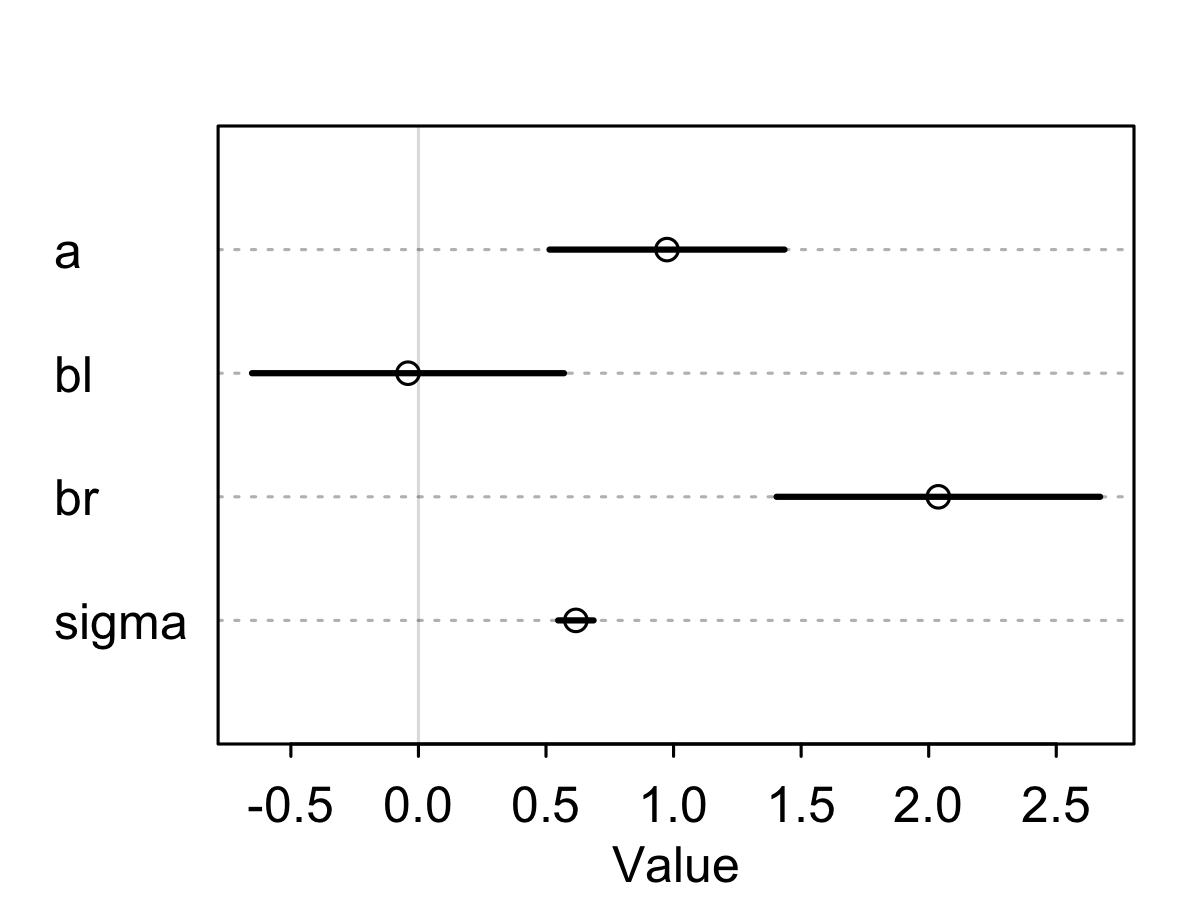

In [166]:
m6.1 <- quap( alist(  height ~ dnorm( mu , sigma ) ,
                      mu <- a + bl*leg_left + br*leg_right , 
                      a ~ dnorm( 10 , 100 ) , bl ~ dnorm( 2 , 10 ), 
                      br ~ dnorm( 2 , 10 ) , sigma ~ dexp( 1 ) ),
                      data=d ) 
plot(precis(m6.1))

**What information does knowing the right leg add to knowing the left leng add to my model?**

In [28]:
options(repr.plot.width=4, repr.plot.height=4, repr.plot.res = 200) #resize plots

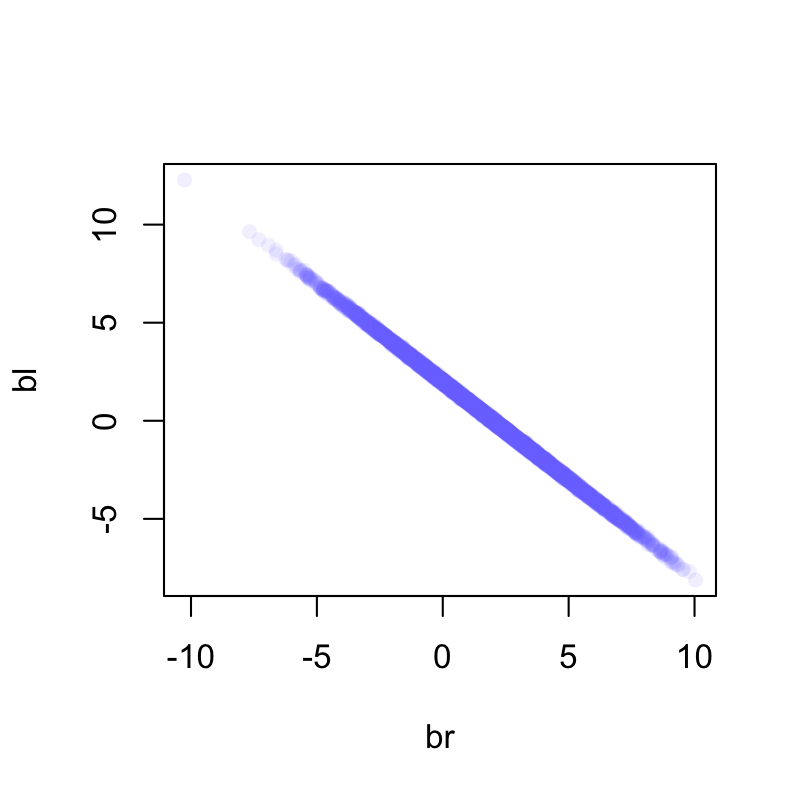

In [30]:
post <- extract.samples(m6.1)
plot( bl ~ br , post , col=col.alpha(rangi2,0.1) , pch=16 )

The joint posterior tells you that for any value of $\beta_r$, you have a $\beta_\ell$ so that $\beta_r+\beta_\ell=2$

Also, predicting $\beta_\ell$ with $\beta_r$ leaves you no residuals to model the height.

You have **infinite combinations** of the two slopes that can give you correct predictions, though making the model of little interpretability.

The model is not wrong, but **cannot answer** the question you ask (importance of one leg knowing the other one)

Important: removal of highly correlated variables is not the way to go. **Understanding the causal model** is what you need to do.

Other variables might govern your model.

<img src="./img/milkExample_dag.png" alt="Drawing" style="width: 500px;"/>

# Post-treatment bias

using predictors variables that are the effect of other predictors

### Simulating anti-fungal treatment

In [33]:
set.seed(71)
# number of plants 
N <- 100
# simulate initial heights 
h0 <- rnorm(N,10,2)
# assign treatments and simulate fungus and growth 
treatment <- rep( 0:1 , each=N/2 )
fungus <- rbinom( N , size=1 , prob=0.5 - treatment*0.4 ) 
h1 <- h0 + rnorm(N, 5 - 3*fungus)
# compose a clean data frame
d <- data.frame( h0=h0 , h1=h1 , treatment=treatment , fungus=fungus ) 
precis(d)

,mean,sd,5.5%,94.5%,histogram
,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
h0,9.95978,2.1011623,6.570328,13.07874,▁▂▂▂▇▃▂▃▁▁▁▁
h1,14.39920,2.6880870,10.618002,17.93369,▁▁▃▇▇▇▁▁
treatment,0.50000,0.5025189,0.000000,1.00000,▇▁▁▁▁▁▁▁▁▇
fungus,0.23000,0.4229526,0.000000,1.00000,▇▁▁▁▁▁▁▁▁▂


### Modeling 
without the post-treatment fungus

In [37]:
options(repr.plot.width=4, repr.plot.height=3, repr.plot.res = 200) #resize plots

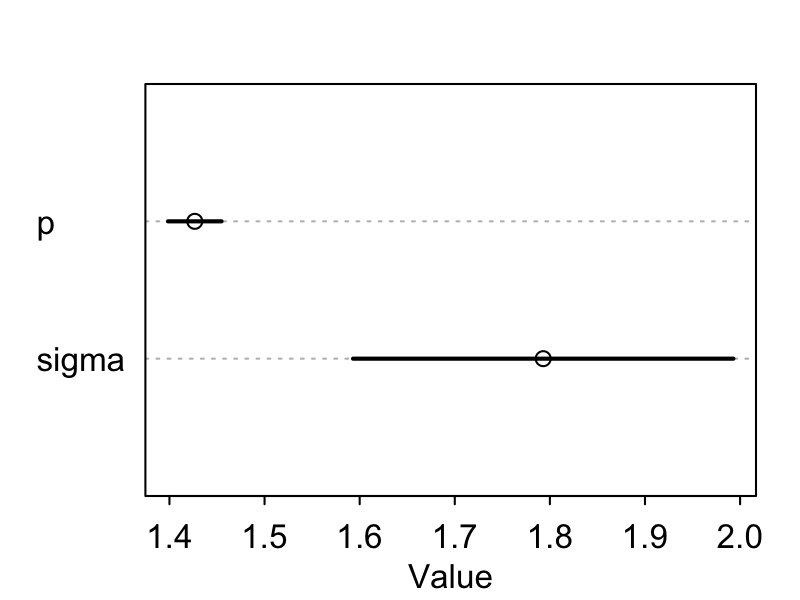

In [38]:
m6.6 <- quap( alist(
        h1 ~ dnorm( mu , sigma ), 
        mu <- h0*p,
        p ~ dlnorm( 0 , 0.25 ), sigma ~ dexp( 1 )), 
        data=d ) 
plot(precis(m6.6))

### Modeling 
with the post-treatment fungus

In [39]:
m6.7 <- quap( alist(
            h1 ~ dnorm( mu , sigma ),
            mu <- h0 * p,
            p <- a + bt*treatment + bf*fungus, 
            a ~ dlnorm( 0 , 0.2 ) , bt ~ dnorm( 0 , 0.5 ), bf ~ dnorm( 0 , 0.5 ),
            sigma ~ dexp( 1 )), 
            data=d ) 

In [40]:
precis(m6.7)

,mean,sd,5.5%,94.5%
,<dbl>,<dbl>,<dbl>,<dbl>
a,1.481390987,0.02451066,1.44221821,1.52056376
bt,0.002412496,0.02986961,-0.04532491,0.05014991
bf,-0.266718012,0.03654768,-0.32512826,-0.20830777
sigma,1.408795661,0.09862040,1.25118122,1.56641010


Once we know that a fungus is present, then knowing that we have done a treatment is not of much importance. 

This because treatment and height are independent conditionally on observing fungi.

In [47]:
options(repr.plot.width=4, repr.plot.height=1, repr.plot.res = 200) #resize plots

library(dagitty)
plant_dag <- dagitty( "dag {
H_0 -> H_1 F -> H_1 T -> F
}")
coordinates( plant_dag ) <- list( x=c(H_0=0,T=2,F=1.5,H_1=1) , y=c(H_0=0,T=0,F=0,H_1=0) )

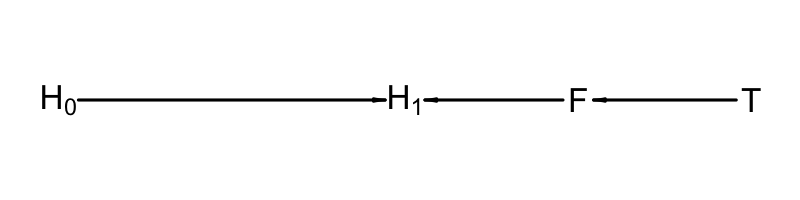

In [48]:
drawdag( plant_dag )

Using multiple models is useful to **understand causal relationships**, not just because we can select one.

# Collider bias

when selection happens in statistical phenomena

In the newsworthy/reliable model ($T \rightarrow S \leftarrow N$): knowing papers are selected tells you something about reliability once you know newsworthiness (and viceversa)

- Selected paper, low reliability --> high newsworthiness
- Any paper, low reliability --> it depends

## SImulating marriage status

Happiness and age influence your marriage status ($A \rightarrow M \leftarrow H$).
- Happier --> more likely to marry
- You can get married every year

In [50]:
library(rethinking)
d <- sim_happiness( seed=1977 , N_years=1000 ) 
precis(d)

,mean,sd,5.5%,94.5%,histogram
,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
age,3.300000e+01,18.768883,4.000000,62.000000,▇▇▇▇▇▇▇▇▇▇▇▇▇
married,3.007692e-01,0.458769,0.000000,1.000000,▇▁▁▁▁▁▁▁▁▃
happiness,-1.000070e-16,1.214421,-1.789474,1.789474,▇▅▇▅▅▇▅▇


<img src="./img/marriage_simulation.png" alt="Drawing" style="width: 1000px;"/>

At some point you will get enough married people to include also the less happy ones.

Looking only at married people will give a negative correlation $Age \sim Happyness$

In [51]:
d2 <- d[ d$age>17 , ] # only adults 
d2$A <- ( d2$age - 18 ) / ( 65 - 18 ) #age 18 is age 0, 65 is 1

In [52]:
d2$mid <- d2$married + 1 
m6.9 <- quap( alist(
            happiness ~ dnorm( mu , sigma ), mu <- a[mid] + bA*A,
            a[mid] ~ dnorm( 0 , 1 ),
            bA ~ dnorm( 0 , 2 ),
            sigma ~ dexp(1)) , 
            data=d2 )

In [56]:
options(repr.plot.width=4, repr.plot.height=2, repr.plot.res = 200) #resize plots

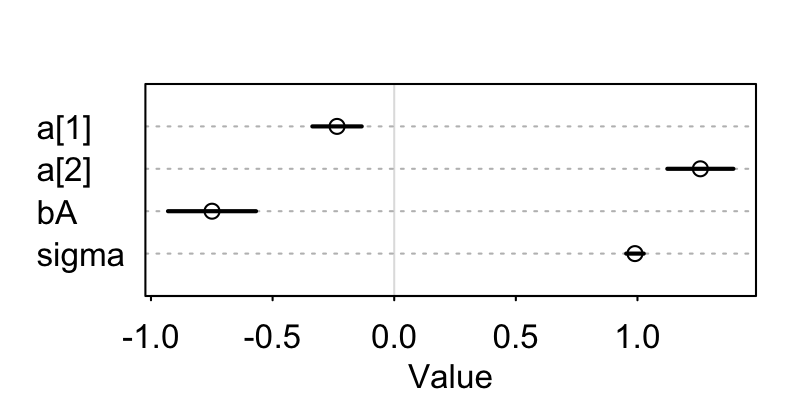

In [57]:
plot(precis(m6.9,depth=2))

Even though happiness has a fixed value at birth!

But if you omit marriage status, age has no effect.

In [58]:
m6.10 <- quap( alist(
    happiness ~ dnorm( mu , sigma ), 
    mu <- a + bA*A,
    a ~ dnorm( 0 , 1 ),
    bA ~ dnorm( 0 , 2 ),
    sigma ~ dexp(1) ) , 
    data=d2 )

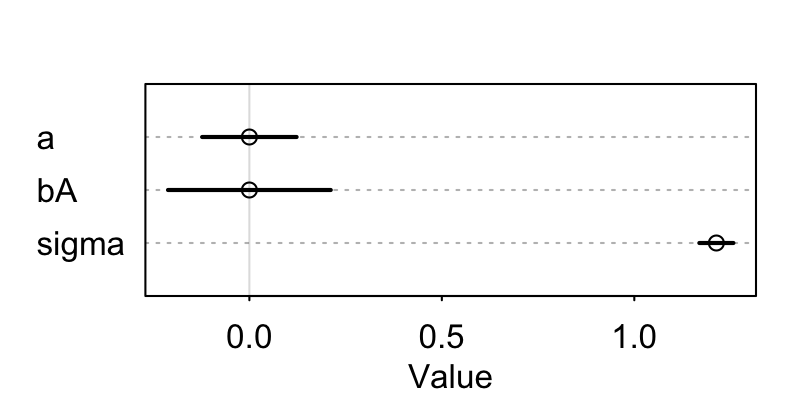

In [59]:
plot(precis(m6.10))

Collider bias can avoided when you sort out your DAG as above.

But collider bias might happen **also with unobserved variables!**

<img src="./img/colliderBiasUnobserved.png" alt="Drawing" style="width: 500px;"/>

P is a collider. Fixing P influences $G \rightarrow C$ through U.

## simulation
Linear models from the DAG above. G has ZERO effect on P and C, U is binary (good/bad neighbourhood)

In [64]:
N <- 200 # number of grandparent-parent-child triads 
b_GP <- 1 # direct effect of G on P
b_GC <- 0 # direct effect of G on C
b_PC <- 1 # direct effect of P on C
b_U<-2 #directeffectofUonPandC

set.seed(1)
U <- 2*rbern( N , 0.5 ) - 1
G <- rnorm( N )
P <- rnorm( N , b_GP*G + b_U*U )
C <- rnorm( N , b_PC*P + b_GC*G + b_U*U ) 
d <- data.frame( C=C , P=P , G=G , U=U )

In [65]:
m6.11 <- quap( alist(
            C ~ dnorm( mu , sigma ), 
            mu <- a + b_PC*P + b_GC*G,
            a ~ dnorm( 0 , 1 ), 
            c(b_PC,b_GC) ~ dnorm( 0 , 1 ), 
            sigma ~ dexp( 1 )), 
data=d )

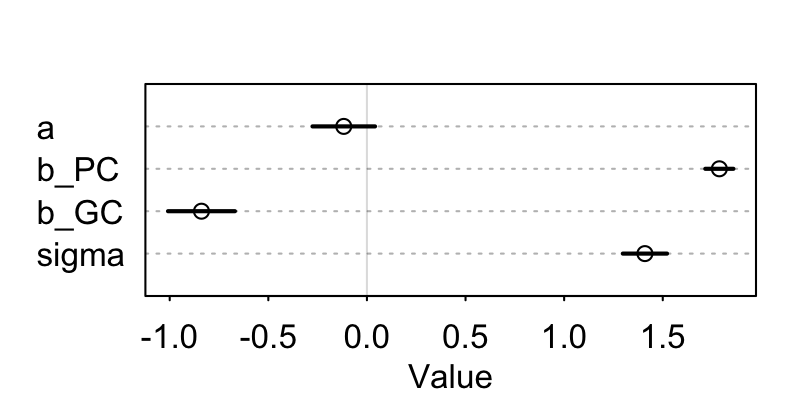

In [67]:
plot(precis(m6.11))

Grandparents have a negative influence on their grandchildren. **No wrong regression**, but wrong causal relationships.

This is the effect of including the collider P as predictor.
Example: knowing P is high tells you that G with low education is associated with a good neighbourhood. Information is flowing between G and U

# Blocking confounder paths

- **Information flows** through specific paths in a causal graph, e.g. in a collider, creating spurious relationships in your models.

- Any DAG has a composition of four elementary confounding paths: **Fork, Pipe, Collider**. Each can have a descendant.

<img src="./img/confounderTypes.png" alt="Drawing" style="width: 800px;"/>

<img src="./img/confounderTypes.png" alt="Drawing" style="width: 800px;"/>

- **Fork**: condition on Z (BLOCK the path) and X, Y becomes cond.indep.
- **Pipe**: condition on Z to *BLOCK* the path betweeen X, Y
- **Collider**: condition on Z *OPENS* the path between X, Y
- **Descendants**: applying one of the above to a descendant will only condition some of the information of Z, creating a partial (un)confounding effect.

# Exercise 6M2
## The importance of conditional association


exercise

In [73]:
library(dagitty)
dag.6m2 <- dagitty( "dag {
X -> Z 
Z -> Y
}")
coordinates(dag.6m2) <- list( x=c(X=0,Z=1,Y=2) , y=c(X=0,Z=0,Y=0) ) 

### Simulation
X,Z negatively correlated

In [84]:
options(repr.plot.width=4, repr.plot.height=1, repr.plot.res = 300) #resize plots

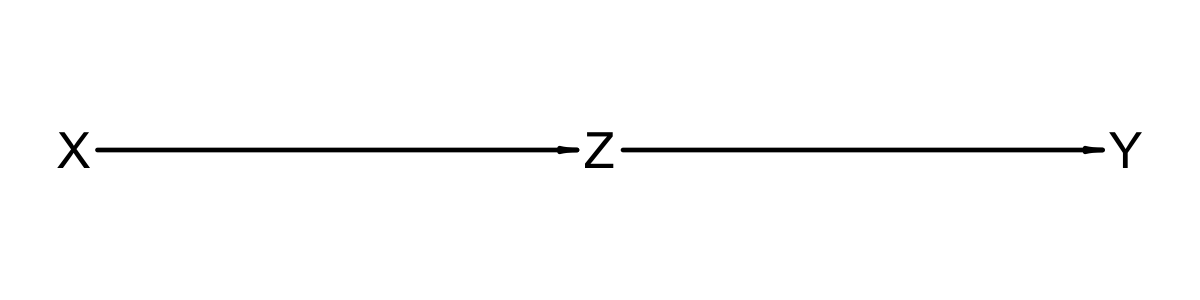

In [85]:
drawdag( dag.6m2 )

In [77]:
N = 100 #Nsamples
set.seed(123)
X = rnorm(N, 2) #root
Z = rnorm(N, -2*X) #pipe collider
Y = rnorm(N, 3*Z+1) #leaf
d.6m2 = data.frame(X=X, Z=Z, Y=Y)

In [91]:
options(repr.plot.width=4, repr.plot.height=3, repr.plot.res = 200) #resize plots

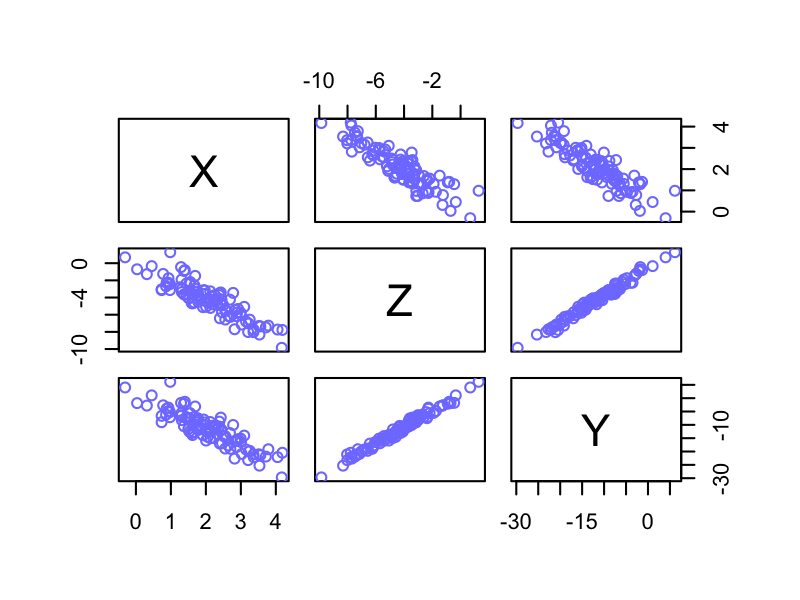

In [92]:
 pairs( ~ X + Z + Y , data=d.6m2 , col=rangi2 )

In [79]:
cor(X,Z)

[1] -0.8888493

In [108]:
options(repr.plot.width=4, repr.plot.height=3, repr.plot.res = 300) #resize plots

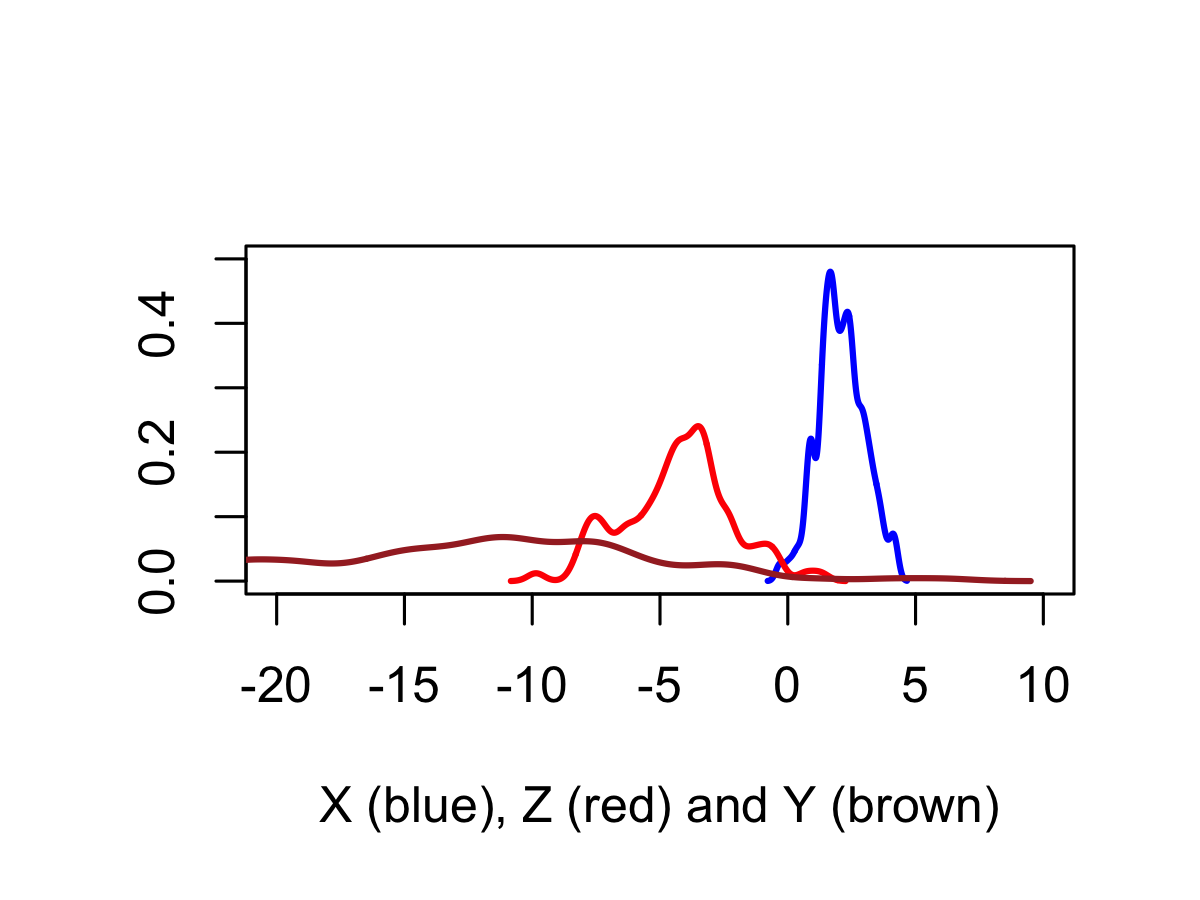

In [110]:
plot(NA,NA, xlim = c(-20,10),ylim = c(0,.5), , xlab="X (blue), Z (red) and Y (brown)", ylab = NA)
dens(X, add=T, col="blue" , lwd=2 )
dens(Z,add = T, col="red" , lwd=2 )
dens(Y,add = T, col="brown" , lwd=2 )

In [121]:
m.6m2 <- quap( alist(
        Y ~ dnorm( mu , sigma ) , 
        mu <- a + bXY*X + bZY*Z,
        a ~ dnorm( 5 , 100 ) ,
        bXY ~ dnorm( -5 , 10 ) ,
        bZY ~ dnorm( -5 , 10 ),
        sigma ~ dexp( 1 ) ),
        data=d.6m2 ) 

Knowing X does not add much information to knowing Z. **Z sucks all the information from its only cause X**, left to be ininfluent in the model, similarly to the post-treatment bias example.

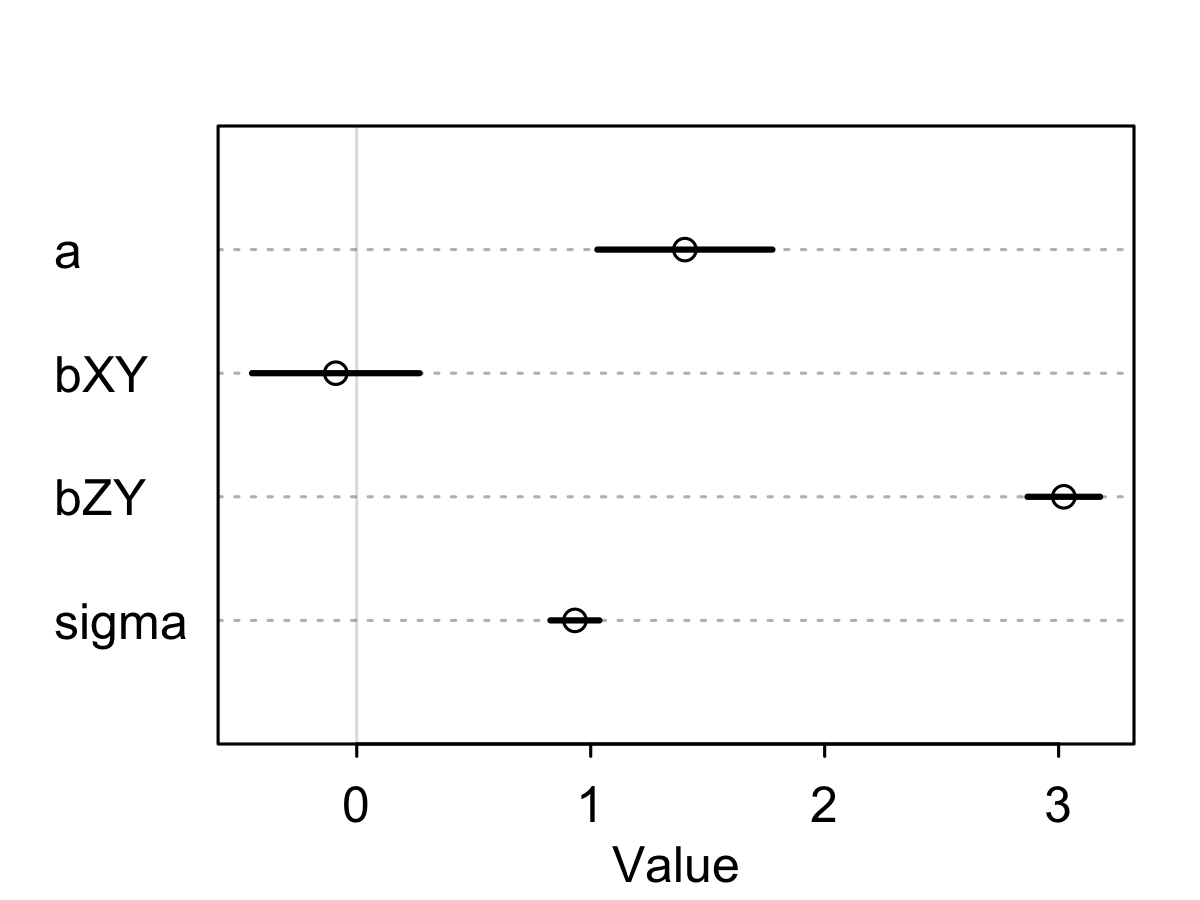

In [123]:
plot( precis(m.6m2))

This because **knowing Z closes the confounding pipe**

In [159]:
impliedConditionalIndependencies(dag.6m2)

X _||_ Y | Z

We do not have same collinearity as in the legs example, **where the output was a collider**. Marginal posteriors are still correlated...

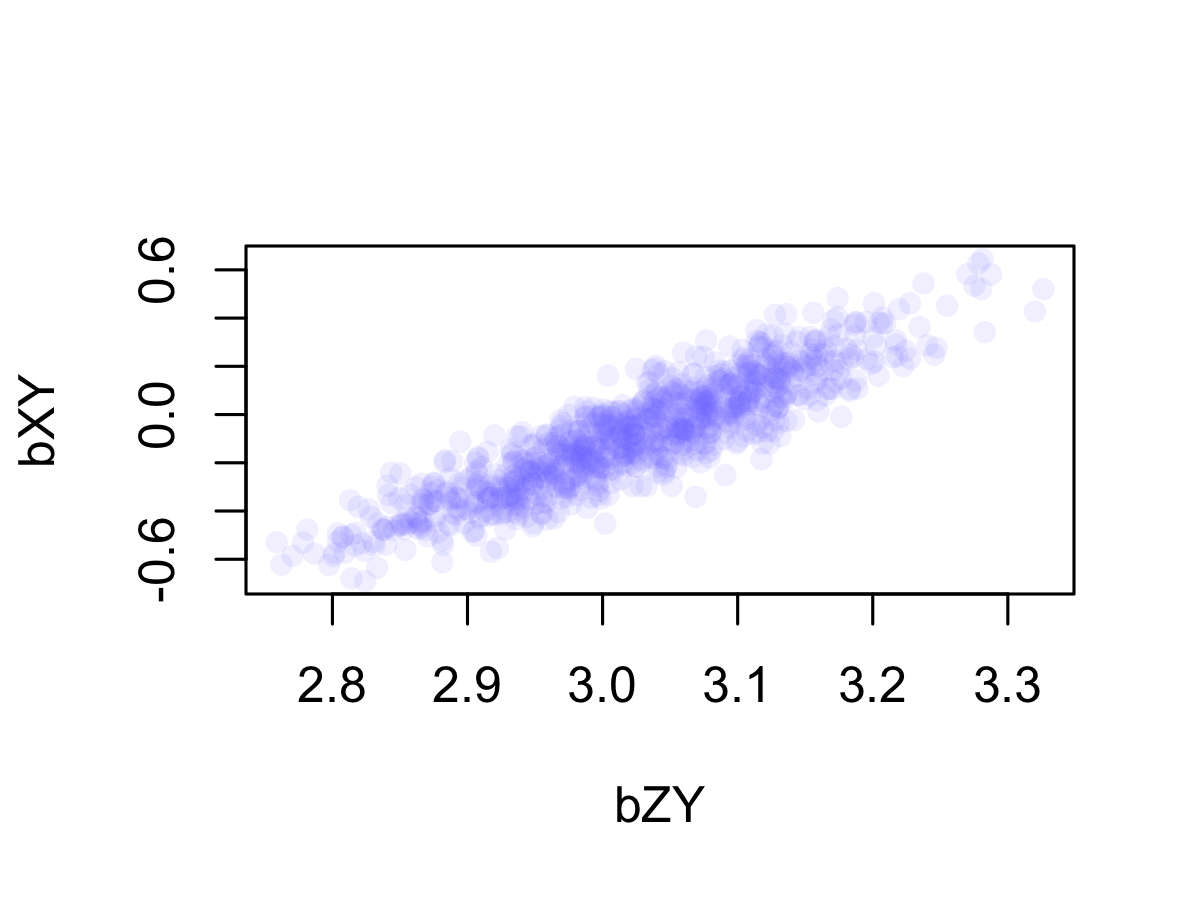

In [151]:
post = extract.samples(m.6m2, n = 1000)
plot( bXY ~ bZY , post , col=col.alpha(rangi2,0.1) , pch=16 )

In [152]:
cor(post$bXY, post$bZY)

[1] 0.8950111

but they do not sum to the effect of including only X

In [157]:
m.6m2.red <- quap( alist(
        Y ~ dnorm( mu , sigma ) , 
        mu <- a + bXY*X,
        a ~ dnorm( 0 , 100 ) ,
        bXY ~ dnorm( 10 , 10 ) ,
        sigma ~ dexp( 1 ) ),
        data=d.6m2 ) 

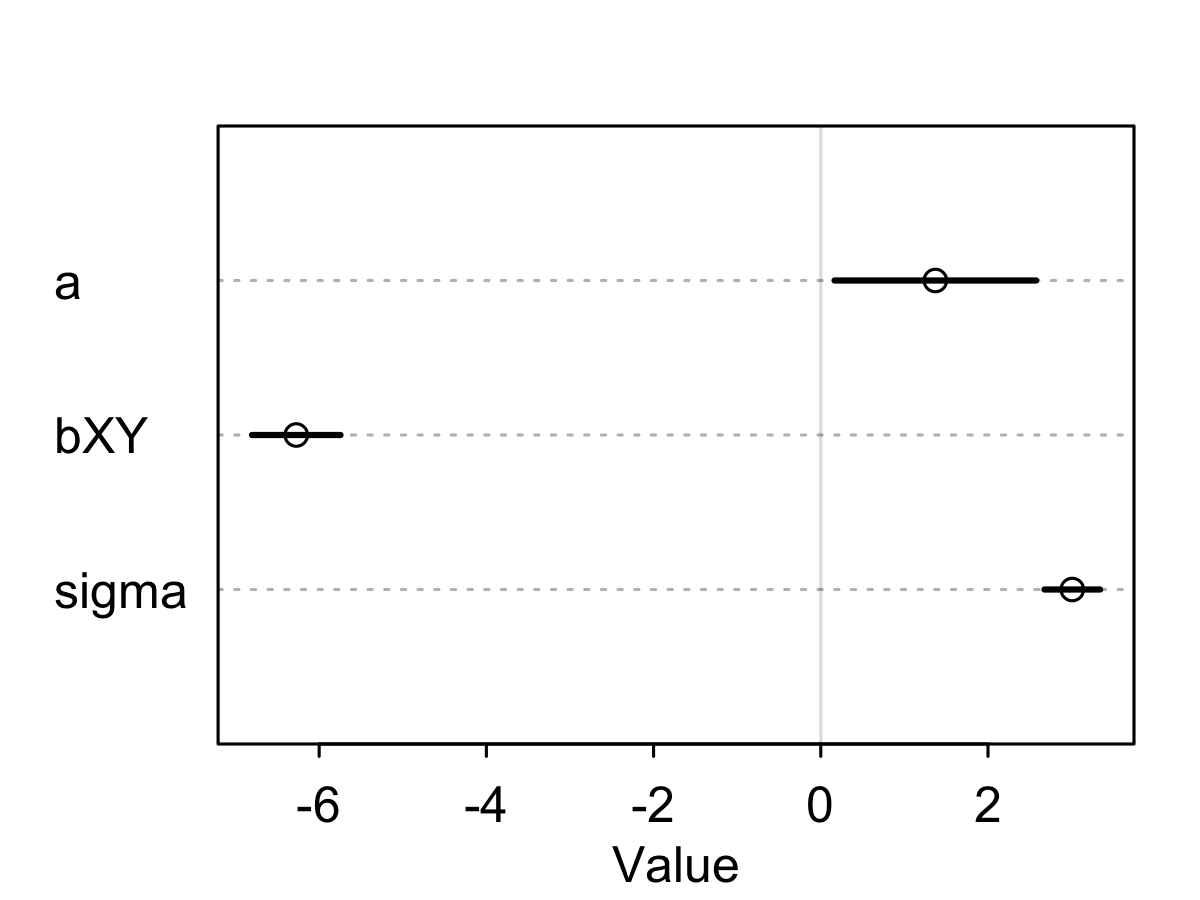

In [158]:
plot(precis(m.6m2.red))